<a href="https://colab.research.google.com/github/charmdust/LLMs-senolytics/blob/main/Test_set_best_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers torch torchvision

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA
import numpy as np
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, f1_score, accuracy_score
from hyperopt import fmin, tpe, space_eval, hp, STATUS_OK, Trials
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

from transformers import AutoTokenizer, AutoModel
import torch

from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

import seaborn as sns

In [1]:
# Upload csv file of senolytics dataset #embeddings_ChemBERTa-77M-MTR.csv
from google.colab import files

uploaded_files = files.upload()

Saving embeddings_ChemBERTa-77M-MTR.csv to embeddings_ChemBERTa-77M-MTR.csv
Saving list_of_compounds_for_computational_screening.csv to list_of_compounds_for_computational_screening.csv


In [3]:
# Senolytic embedding dataset
embeddings_df = pd.read_csv('embeddings_ChemBERTa-77M-MTR.csv', index_col=0)
embeddings_unlabelled_df= embeddings_df.drop(['senolytic'], axis=1)

In [4]:
# Senolytic dataset - test set
test_df = pd.read_csv('list_of_compounds_for_computational_screening.csv')
test_df

,Name,Library,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,(-)-Arctigenin,Selleck,COC1=C(O)C=CC(=C1)CC2C(COC2=O)CC3=CC=C(OC)C(=C...,1.763934,816.314286,19.388541,15.728578,15.728578,13.049575,8.787575,...,0,0,0,0,0,0,0,0,0,0.753438
1,(-)-Blebbistatin,Targetmol 3338,Cc1ccc2N=C3N(CC[C@@]3(O)C(=O)c2c1)c1ccccc1,1.880486,797.989385,15.319626,12.282905,12.282905,10.593172,7.390657,...,0,0,0,0,0,0,0,0,0,0.879020
2,(-)-Borneol,Selleck,CC1(C)C2CCC1(C)C(O)C2,2.396255,185.311799,8.276021,7.723234,7.723234,4.982999,4.663847,...,0,0,0,0,0,0,0,0,0,0.566800
3,(-)-Cotinine,Targetmol 3338,CN1[C@@H](CCC1=O)c1cccnc1,2.236360,309.960601,9.259149,7.603640,7.603640,6.287694,4.444035,...,0,0,0,0,0,0,0,0,0,0.647201
4,(-)-Epicatechin gallate,Selleck,OC1=CC2=C(CC(OC(=O)C3=CC(=C(O)C(=C3)O)O)C(O2)C...,1.721352,1196.568791,23.153972,16.258499,16.258499,15.133938,9.330270,...,0,0,0,0,0,0,0,0,0,0.235487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,α-Terpineol,Selleck,CC1=CCC(CC1)C(C)(C)O,2.538576,162.201816,8.483128,7.723234,7.723234,4.999019,4.379255,...,0,0,0,0,0,0,0,0,0,0.575260
4336,β-Alanine,Selleck,NCCC(O)=O,2.831257,52.754888,4.991564,3.347026,3.347026,2.770056,1.689533,...,0,0,0,0,0,0,0,0,0,0.475392
4337,β-Caryophyllene,Selleck,CC/1=C\CCC(=C)C2CC(C)(C)C2CC1,2.119623,293.160171,11.052042,10.474691,10.474691,7.004837,6.338317,...,0,0,0,0,0,0,0,0,0,0.500562
4338,β-Elemonic Acid,Targetmol 3338,C\C(C)=C/CC[C@@H]([C@@H]1CC[C@]2(C)C3=C(CC[C@@...,1.695803,903.502499,24.396977,22.144179,22.144179,15.287200,13.412878,...,0,0,0,0,0,0,0,0,0,0.431968


## Get embeddings for test set

In [5]:
smiles = test_df['SMILES'].astype(str).tolist()

In [9]:
# Split into chunks as colab crashed with full dataset
smiles_1 = smiles[0:1500]
smiles_2 = smiles[1500:3000]
smiles_3 = smiles[3000:]

In [10]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def gen_embeddings (model, tokenizer, smiles):
    #Tokenize sentences
    encoded_input = tokenizer(smiles, padding=True, truncation=True, max_length=128, return_tensors='pt')

    #Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    #Perform pooling. In this case, mean pooling
    return mean_pooling(model_output, encoded_input['attention_mask'])

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

#tokenizer_2 = AutoTokenizer.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k")
#model_2 = AutoModel.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k")


chemBERTa_2_test_embeddings_1 = gen_embeddings(model, tokenizer,smiles_1)

#st_sentence_embeddings = gen_embeddings(model_2, tokenizer_2)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
chemBERTa_2_test_embeddings_2 = gen_embeddings(model, tokenizer,smiles_2)

In [12]:
chemBERTa_2_test_embeddings_3 = gen_embeddings(model, tokenizer,smiles_3)

In [13]:
embeddings_test_df_1 = pd.DataFrame(chemBERTa_2_test_embeddings_1)
embeddings_test_df_1

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.015999,0.447090,-0.064498,0.007834,0.249663,-0.129743,0.019870,0.388460,0.460315,0.333144,...,-0.192478,-0.028564,0.361139,-0.191047,0.421456,0.255147,-0.405248,0.007735,-0.202822,-0.565957
1,-0.162281,-0.168639,-0.056570,-0.053624,-0.232558,-0.021849,-0.595615,0.446200,1.155252,0.770201,...,0.242932,-0.382648,0.381507,-0.381017,0.865323,0.397636,0.072945,-0.317535,-0.831613,-0.976863
2,-0.217092,-0.015165,-0.008606,0.019475,-0.095752,0.140221,-0.303309,0.368919,0.989612,0.566312,...,-0.069499,0.251827,0.450819,0.067432,0.392029,0.217081,-0.002524,-0.184265,-0.501855,-0.562045
3,0.082067,-0.036083,0.000781,0.224541,-0.286423,0.087893,-0.159557,0.388663,1.253454,0.958874,...,0.346133,-0.217270,0.527730,-0.162094,0.553649,0.563702,-0.127482,-0.122900,-0.797646,-0.770542
4,-0.358998,0.603541,-0.126494,-0.100830,0.640436,-0.605037,0.255124,0.085224,0.408842,0.334106,...,0.236037,0.271649,0.386647,0.029748,0.434413,0.024351,-0.725533,0.225216,-0.016629,-0.597636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-0.042812,-0.055931,-0.083928,-0.116147,0.094486,-0.011687,-0.336828,0.157682,-0.015651,0.612670,...,-0.388692,-0.361223,0.442881,-0.476847,0.558131,0.014775,0.216589,0.283854,-0.350803,-0.482452
1496,-0.121931,-0.090184,-0.042331,-0.228506,-0.216776,0.074839,-0.681562,0.605939,0.995063,0.924971,...,0.153192,-0.230655,0.275917,-0.392969,0.727698,0.253267,0.093154,-0.052828,-0.637587,-0.608289
1497,-0.196772,0.284384,-0.083806,-0.356320,-0.203018,0.124803,-0.206594,0.373017,0.803866,0.544679,...,-0.203244,0.155003,0.558742,-0.014099,0.356620,0.524395,-0.341758,-0.163389,-0.533205,-1.081743
1498,0.096926,0.221390,-0.012452,0.499217,-0.229238,0.042618,-0.001573,0.468268,1.186432,1.390496,...,0.401185,0.088484,0.578144,0.416028,0.614970,0.334874,-0.359887,-0.170395,-0.749301,-0.816329


In [14]:
embeddings_test_df_2 = pd.DataFrame(chemBERTa_2_test_embeddings_2)
embeddings_test_df_3 = pd.DataFrame(chemBERTa_2_test_embeddings_3)

In [16]:
embeddings_test_df = pd.concat([embeddings_test_df_1, embeddings_test_df_2, embeddings_test_df_3])

In [18]:
embeddings_test_df

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.015999,0.447090,-0.064498,0.007834,0.249663,-0.129743,0.019870,0.388460,0.460315,0.333144,...,-0.192478,-0.028564,0.361139,-0.191047,0.421456,0.255147,-0.405248,0.007735,-0.202822,-0.565957
1,-0.162281,-0.168639,-0.056570,-0.053624,-0.232558,-0.021849,-0.595615,0.446200,1.155252,0.770201,...,0.242932,-0.382648,0.381507,-0.381017,0.865323,0.397636,0.072945,-0.317535,-0.831613,-0.976863
2,-0.217092,-0.015165,-0.008606,0.019475,-0.095752,0.140221,-0.303309,0.368919,0.989612,0.566312,...,-0.069499,0.251827,0.450819,0.067432,0.392029,0.217081,-0.002524,-0.184265,-0.501855,-0.562045
3,0.082067,-0.036083,0.000781,0.224541,-0.286423,0.087893,-0.159557,0.388663,1.253454,0.958874,...,0.346133,-0.217270,0.527730,-0.162094,0.553649,0.563702,-0.127482,-0.122900,-0.797646,-0.770542
4,-0.358998,0.603541,-0.126494,-0.100830,0.640436,-0.605037,0.255124,0.085224,0.408842,0.334106,...,0.236037,0.271649,0.386647,0.029748,0.434413,0.024351,-0.725533,0.225216,-0.016629,-0.597636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,-0.074408,0.152514,-0.019172,-0.041170,-0.094130,-0.026386,-0.221204,0.530042,0.981029,0.789312,...,0.122846,0.033057,0.469565,0.051910,0.478696,0.282265,-0.152491,-0.087252,-0.533910,-0.492262
1336,-0.251557,0.256073,-0.000195,-0.075419,-0.288665,0.140940,0.216912,0.194855,0.480798,-0.009994,...,-0.011760,-0.238926,0.459643,0.099511,0.221043,0.170666,-0.305677,-0.190266,-0.347147,-0.367335
1337,-0.052847,-0.104021,-0.009910,-0.086056,-0.140885,-0.062344,-0.471855,0.328054,1.006909,0.818338,...,-0.015477,0.053431,0.386559,-0.087835,0.300453,0.216072,0.118490,-0.101798,-0.360060,-0.569058
1338,-0.412817,0.024246,-0.045485,-0.156406,-0.094835,0.133908,-0.462214,0.215728,1.085659,0.889012,...,-0.432041,0.269942,0.501222,-0.220169,0.351724,0.067449,0.315461,0.107205,-0.397632,-0.553345


In [20]:
# Save dataframe to csv
embeddings_test_df.to_csv('test_embeddings.csv', index=True)

PCA

In [21]:
# Scale dataset https://www.kdnuggets.com/2023/05/principal-component-analysis-pca-scikitlearn.html
std_scaler = StandardScaler()
std_scaler.fit(embeddings_unlabelled_df)
scaled_embeddings_df = std_scaler.transform(embeddings_unlabelled_df)
scaled_test_df = std_scaler.transform(embeddings_test_df)




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [22]:
# Choose 52 to explain 90% variance of training data
pca = PCA(n_components=52)
pca.fit(scaled_embeddings_df)
pca_transformed_embeddings = pca.transform(scaled_embeddings_df)
pca_test_embeddings = pca.transform(scaled_test_df)

array([[ 1.44620994e+01, -2.50945609e+00, -3.56551840e+00, ...,
        -4.30356401e-02,  1.12116702e+00, -6.79604488e-01],
       [-1.24485457e+01,  2.44110186e+00, -2.88094254e+00, ...,
        -7.65666563e-01,  6.01687971e-01,  1.76153357e-02],
       [ 8.13190025e-01, -4.94549492e+00,  1.21539988e+00, ...,
         6.74754412e-01, -6.66342361e-01, -1.84575432e-01],
       ...,
       [-8.19715025e-01, -3.32037753e+00, -2.57652123e+00, ...,
         6.33331852e-01, -1.54300642e-01,  3.87268255e-01],
       [-2.25486485e+00, -1.04315186e+01, -4.42173776e+00, ...,
         8.21798811e-01, -8.68463183e-01,  7.88203459e-01],
       [-2.49610093e+00,  5.75415102e+00,  3.39937836e+00, ...,
        -1.08997642e-02,  3.01905479e-01, -6.81179643e-02]])

In [25]:
pca_transformed_embeddings_df = pd.DataFrame(pca_transformed_embeddings)
pca_test_embeddings_df = pd.DataFrame(pca_test_embeddings)
pca_test_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,14.462099,-2.509456,-3.565518,-4.358227,-1.306719,-6.017691,1.314763,-1.169261,-0.109314,1.282287,...,-1.398699,-0.254448,-0.592395,1.234795,1.249868,0.710660,-1.462981,-0.043036,1.121167,-0.679604
1,-12.448546,2.441102,-2.880943,-2.138210,1.926592,2.103481,-4.514025,1.214933,3.622077,-3.801411,...,-0.353844,0.461280,0.113408,-0.855296,-1.029738,0.951075,-0.669280,-0.765667,0.601688,0.017615
2,0.813190,-4.945495,1.215400,-6.177967,-2.510111,0.587789,-2.886360,-2.545408,-2.664223,0.099351,...,0.923690,-0.297805,-0.329732,-0.635240,0.023614,0.049325,-0.750334,0.674754,-0.666342,-0.184575
3,-2.290944,-1.756744,1.960060,-10.101435,0.205192,2.407785,0.124273,-1.109965,2.497806,-1.671020,...,0.243641,0.434806,0.775345,0.795419,0.752790,-0.335320,-0.214036,0.562424,0.204263,-0.486864
4,18.387909,-4.416875,-5.403558,4.977582,1.015129,0.021157,-6.004883,8.683225,-0.431095,2.280151,...,1.558729,1.654053,0.746825,0.618846,2.365498,1.502897,1.248217,0.324676,-0.050991,0.866085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,2.742460,-1.475390,0.285700,-7.769209,-0.862422,0.268997,-1.442589,-1.569672,-2.580721,0.732698,...,0.711594,0.066145,1.151918,-1.336524,1.661352,-0.254100,-1.622546,0.179611,1.145975,0.990875
4336,11.852829,9.099861,4.857801,-9.569574,0.778912,1.456532,-0.831846,-2.722682,-6.624451,2.091117,...,-0.235064,0.213509,-0.078649,0.099329,0.117581,0.667014,-0.530990,-1.696473,0.457228,0.935746
4337,-0.819715,-3.320378,-2.576521,-6.064727,-1.414494,-1.134016,-2.615895,-2.981849,1.252472,1.110967,...,0.749291,-0.057864,-0.135387,-1.327170,1.375011,-0.624729,-0.441275,0.633332,-0.154301,0.387268
4338,-2.254865,-10.431519,-4.421738,0.768781,-3.012591,-2.905828,-4.169582,-4.686741,-2.982586,0.752507,...,1.396522,-1.100862,-1.305842,-1.763136,0.708371,-0.790269,-0.070900,0.821799,-0.868463,0.788203


In [26]:
X_train = pca_transformed_embeddings_df
y_train = embeddings_df['senolytic']

In [46]:
X_test = pca_test_embeddings_df


In [47]:
# Shuffle dataset

X_train, y_train = shuffle(X_train, y_train, random_state=42)
#X_test = shuffle(X_test, random_state=42)


## Best model

In [29]:

best_params_knn = {'weights': 'distance', 'n_neighbors': 5, 'algorithm': 'brute'}

In [51]:
knn_best = KNeighborsClassifier(**best_params_knn)

knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)

In [52]:
y_pred.sum()

34

In [53]:
test_df['prediction knn'] = y_pred

In [54]:
test_df_predicted_knn = test_df[test_df['prediction knn']==1]

In [55]:
test_df_predicted_knn

,Name,Library,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,...,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed,prediction,prediction knn
108,20(R)-Propanaxadiol,Targetmol 3338,C\C(C)=C/CC[C@@](C)(O)[C@H]1CC[C@]2(C)[C@@H]1[...,1.225638,1368.350456,40.628663,34.251045,34.251045,25.583261,20.863808,...,0,0,0,0,0,0,0,0.114795,1,1
396,Anisindione,Selleck,COC1=CC=C(C=C1)C2C(=O)C3=C(C=CC=C3)C2=O,2.032978,620.949193,13.405413,10.420897,10.420897,9.219545,6.035364,...,0,0,0,0,0,0,0,0.771773,1,1
457,Ascomycin (FK520),Selleck,CCC1/C=C(C)/CC(C)CC(OC)C2OC(O)(C(C)CC2OC)C(=O)...,1.763743,1430.854500,41.482034,35.108624,35.108624,26.483058,20.776667,...,0,0,0,0,0,0,0,0.195726,1,1
470,Astragaloside A,Targetmol 3338,CC(C)(O)[C@H]1CC[C@](C)(O1)[C@H]1[C@@H](O)C[C@...,1.148792,1455.821545,40.051313,33.581943,33.581943,25.510111,20.867657,...,0,0,0,0,0,0,0,0.162354,1,1
501,Avermectin B1,Selleck,CCC(C)C1OC2(CC3CC(C\C=C(C)\C(OC4CC(OC)C(OC5CC(...,1.182608,1725.637571,44.672269,38.215876,38.215876,29.497426,22.859695,...,0,0,0,0,0,0,0,0.210064,1,1
988,Chikusetsusaponin IVa,Targetmol 3338,C[C@]12CC[C@@H](C([C@@H]1CC[C@@]1([C@@H]2CC=C2...,1.155946,1562.792020,41.128663,33.965627,33.965627,25.986343,20.790423,...,0,0,0,0,0,0,0,0.109716,1,1
1172,Cyasterone,Targetmol 3338,O1C(=O)[C@H]([C@@H]([C@H]1C)C[C@H]([C@@](C)([C...,1.441524,1005.865684,27.292164,22.684063,22.684063,17.074894,14.029735,...,0,0,0,0,0,0,0,0.353607,1,1
1365,Dioscin,Targetmol 3338,C[C@H]1[C@H]2[C@H](C[C@H]3[C@@H]4CC=C5C[C@H](C...,0.915995,1592.540511,43.498542,36.478276,36.478276,28.900395,23.217479,...,0,0,0,0,0,0,0,0.168241,1,1
1366,Diosgenin,Targetmol 3338,C[C@H]1[C@H]2[C@H](C[C@H]3[C@@H]4CC=C5C[C@@H](...,1.282199,736.390210,20.888541,19.530930,19.530930,14.267258,12.960682,...,0,0,0,0,0,0,0,0.515749,1,1
1549,Esculentoside A,Targetmol 3338,[C@@H]1([C@H](C[C@]2([C@H]([C@@]1(CO)C)CC[C@@]...,1.112741,1607.748278,42.542877,34.528196,34.528196,27.117700,21.026700,...,0,0,0,0,0,0,0,0.092301,1,1


In [58]:
true_senolytics = ['Periplocin', 'Oleandrin', 'Ginkgetin']

for senolytic in true_senolytics:
  if senolytic in list(test_df_predicted_knn['Name']):
    print(senolytic)

Periplocin
Oleandrin


XGBoost

In [67]:
best_params_xgb = {'min_child_weight': 3,
 'max_depth': 20,
 'learning_rate': 0.3,
 'gamma': 0.1,
 'colsample_bytree': 0.9}

In [90]:
xgb_best = xgb.XGBClassifier(random_state=42,  **best_params_xgb)#, scale_pos_weight = len(embeddings_df[embeddings_df['senolytic']==0])/len(embeddings_df[embeddings_df['senolytic']==1]))

xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_test)



In [91]:
sum(y_pred)

10

In [92]:
y_predict_proba = xgb_best.predict_proba(X_test)

In [93]:
test_df['prediction probability xgboost'] = y_predict_proba[:,1]

In [94]:
test_df.sort_values(by=['prediction probability xgboost'], ascending=False)

,Name,Library,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed,prediction,prediction knn,prediction probability xgboost
2769,Nemiralisib (GSK2269557),Selleck,CC(C)N1CCN(CC1)CC2=CN=C(O2)C3=CC(=CC4=C3C=N[NH...,1.318698,1402.738373,22.363232,19.006139,19.006139,16.153000,11.606203,...,0,0,0,0,0,0,0.406817,0,0,0.778063
2911,Oleandrin,Targetmol 3338,CO[C@H]1C[C@H](O[C@H]2CC[C@@]3(C)[C@H](CC[C@@H...,1.193418,1075.386853,29.319262,25.174086,25.174086,19.390851,15.679297,...,0,0,0,0,0,0,0.372966,1,1,0.757008
1380,Dirithromycin,Selleck,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,1.832795,1292.255163,43.490470,37.583253,37.583253,27.019166,21.352388,...,0,0,0,0,2,0,0.141732,0,0,0.729329
369,Amphotericin B,Selleck,CC1OC(OC/2CC3OC(O)(CC(O)CC(O)C(O)CCC(O)CC(O)CC...,1.859385,1665.867991,48.431782,37.578252,37.578252,30.615496,22.317848,...,0,0,0,0,0,0,0.173524,0,0,0.672478
1071,Clarithromycin,Selleck,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,2.221952,1187.576454,39.670479,33.898984,33.898984,23.986179,18.882883,...,0,0,0,0,0,0,0.265829,0,0,0.670131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,Abrine,Targetmol 3338,Cn1cc(C[C@H](N)C(O)=O)c2ccccc12,2.415686,530.798324,11.706742,9.051234,9.051234,7.592224,5.106586,...,0,0,0,0,0,0,0.811116,0,0,0.000024
2511,Melphalan,Selleck,NC(CC1=CC=C(C=C1)N(CCCl)CCCl)C(O)=O,2.706795,392.134620,14.250712,10.558240,12.070098,9.078917,6.023493,...,0,0,0,0,0,0,0.720239,0,0,0.000021
435,Arecoline HBr,Selleck,Br.COC(=O)C1=CCCN(C)C1,0.000001,191.496882,8.267585,7.370629,9.083701,5.236382,3.696643,...,0,0,0,0,0,0,0.635899,0,0,0.000019
2277,L-Threonine,Selleck,CC(O)C(N)C(O)=O,3.637683,91.284213,6.732051,4.534726,4.534726,3.553418,2.218622,...,0,0,0,0,0,0,0.425096,0,0,0.000019


In [97]:
test_df[test_df['Name'].isin(true_senolytics)]


,Name,Library,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed,prediction,prediction knn,prediction probability xgboost
1800,Ginkgetin,Targetmol 3338,COc1cc(O)c2c(c1)oc(cc2=O)-c1ccc(OC)c(c1)-c1c(O...,1.621524,2139.918067,29.706013,22.166547,22.166547,20.176274,12.540069,...,0,0,0,0,0,0,0.202586,0,0,0.003911
2911,Oleandrin,Targetmol 3338,CO[C@H]1C[C@H](O[C@H]2CC[C@@]3(C)[C@H](CC[C@@H...,1.193418,1075.386853,29.319262,25.174086,25.174086,19.390851,15.679297,...,0,0,0,0,0,0,0.372966,1,1,0.757008
3078,Periplocin,Targetmol 3338,CO[C@H]1C[C@H](O[C@H]2CC[C@]3(C)[C@H]4CC[C@]5(...,0.993965,1277.170332,35.095283,29.109205,29.109205,23.174638,18.294571,...,0,0,0,0,0,0,0.163801,1,1,0.029321


In [99]:
test_df[test_df['prediction probability xgboost']>0.4]

,Name,Library,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed,prediction,prediction knn,prediction probability xgboost
369,Amphotericin B,Selleck,CC1OC(OC/2CC3OC(O)(CC(O)CC(O)C(O)CCC(O)CC(O)CC...,1.859385e+00,1665.867991,48.431782,37.578252,37.578252,30.615496,22.317848,...,0,0,0,0,0,0,0.173524,0,0,0.672478
459,Asiatic acid,Targetmol 3338,C[C@@H]1CC[C@@]2(CC[C@@]3(C(=CC[C@H]4[C@]3(CC[...,1.621932e+00,929.707645,25.767220,22.679866,22.679866,16.226505,14.137020,...,0,0,0,0,0,0,0.408691,0,0,0.556803
1071,Clarithromycin,Selleck,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,2.221952e+00,1187.576454,39.670479,33.898984,33.898984,23.986179,18.882883,...,0,0,0,0,0,0,0.265829,0,0,0.670131
1110,Coenzyme Q10,Targetmol 3338,CC1=C(C(=O)C(=C(C1=O)OC)OC)C/C=C(\C)/CC/C=C(\C...,2.305933e+00,1844.232906,47.157915,42.841525,42.841525,29.978580,24.137761,...,0,0,0,0,0,0,0.051463,0,0,0.497955
1366,Diosgenin,Targetmol 3338,C[C@H]1[C@H]2[C@H](C[C@H]3[C@@H]4CC=C5C[C@@H](...,1.282199e+00,736.390210,20.888541,19.530930,19.530930,14.267258,12.960682,...,0,0,0,0,0,0,0.515749,1,1,0.547563
1380,Dirithromycin,Selleck,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,1.832795e+00,1292.255163,43.490470,37.583253,37.583253,27.019166,21.352388,...,0,0,0,0,2,0,0.141732,0,0,0.729329
2066,Indigo,Selleck,O=C1\C(NC2=C1C=CC=C2)=C\3NC4=C(C=CC=C4)C3=O,1.845704e+00,738.129101,13.689870,10.435299,10.435299,9.754020,6.312949,...,0,0,0,0,0,0,0.716691,0,0,0.590066
2769,Nemiralisib (GSK2269557),Selleck,CC(C)N1CCN(CC1)CC2=CN=C(O2)C3=CC(=CC4=C3C=N[NH...,1.318698e+00,1402.738373,22.363232,19.006139,19.006139,16.153000,11.606203,...,0,0,0,0,0,0,0.406817,0,0,0.778063
2880,Nystatin (Fungicidin),Selleck,CC1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)CC2(O)CC(O)C...,1.837305e+00,1619.952954,48.431782,37.837765,37.837765,30.615496,22.634345,...,0,0,0,0,0,0,0.175292,0,0,0.443004
2911,Oleandrin,Targetmol 3338,CO[C@H]1C[C@H](O[C@H]2CC[C@@]3(C)[C@H](CC[C@@H...,1.193418e+00,1075.386853,29.319262,25.174086,25.174086,19.390851,15.679297,...,0,0,0,0,0,0,0.372966,1,1,0.757008


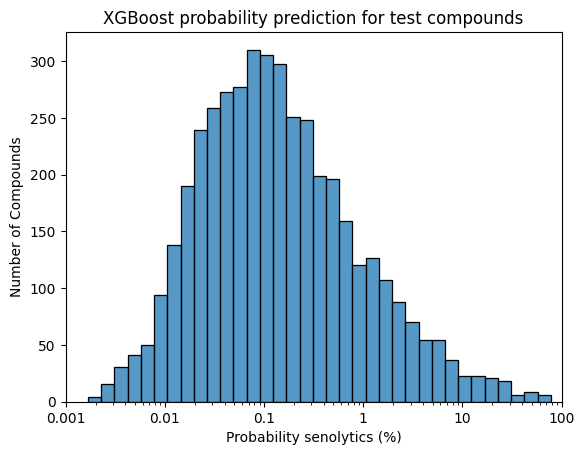

In [135]:
from matplotlib.ticker import ScalarFormatter
sns.histplot(data=test_df, x=100*test_df["prediction probability xgboost"],
    log_scale=True)

plt.title("XGBoost probability prediction for test compounds")
plt.ylabel('Number of Compounds')
plt.xlabel('Probability senolytics (%)')
#plt.xscale('log')
#plt.xticks([0.001, 0.01, 0.1, 1, 100])  # Set label locations.)
plt.xlim([0.001, 100])
# Define the desired tick positions and labels
tick_positions = [0.001, 0.01, 0.1, 1, 10, 100]
tick_labels = ['0.001', '0.01', '0.1', '1', '10', '100']

# Set the tick positions and labels on the x-axis
plt.xticks(tick_positions, tick_labels)
plt.show()